# Comparing Decision Tree and Random Forest Classifier

**Author: Daniel Hassler**

## Sample Data Used in Classification

To compare a DecisionTree and a RandomForestClassifier, the first step I
took was to gather some data and run some visualizations and analysis.
Through Kaggle, I was able to obtain a small dataset on person features
and their BMI (Body Mass Index) data. The data consists of just around
400 samples with features: gender, height, and weight, and the goal is
to predict BMI.

In [1]:
```{python}
import numpy as np
import sklearn
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import matplotlib.pyplot as plt
```


In [2]:
```{python}
data = pd.read_csv("./datasets/bmi_train.csv")
category_mapping = {'Male': 0, 'Female': 1}
data['Gender_Encoded'] = data['Gender'].map(category_mapping) # converts categorical data to numeric data.
X = data.drop(['Gender','Index'], axis=1)
y = data.drop(['Gender', 'Gender_Encoded', 'Height', 'Weight'], axis=1)
print("All X shape: ", X.shape)
print("All y shape: ", y.shape)

validation_data = pd.read_csv("./datasets/bmi_validation.csv")
print("Validation data shape: ", validation_data.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
```


All X shape:  (400, 3)
All y shape:  (400, 1)
Validation data shape:  (100, 3)
X_train shape:  (320, 3)
y_train shape:  (320, 1)
X_test shape:  (80, 3)
y_test shape:  (80, 1)

In the above code snippet, I first populated my data into a Pandas
dataframe and then split up the data into a “training” and “testing”
datasets. I decided to go with an 80/20% split between train and test
(with its corresponding labels), as that seems to be the most standard
approach in the industry. The significant benefit here is that I possess
labeled data on both sets, a challenge in practice. This enables me to
make comparisons between predictions and outcomes on my data,
eliminating the need to procure any additional “test” data.

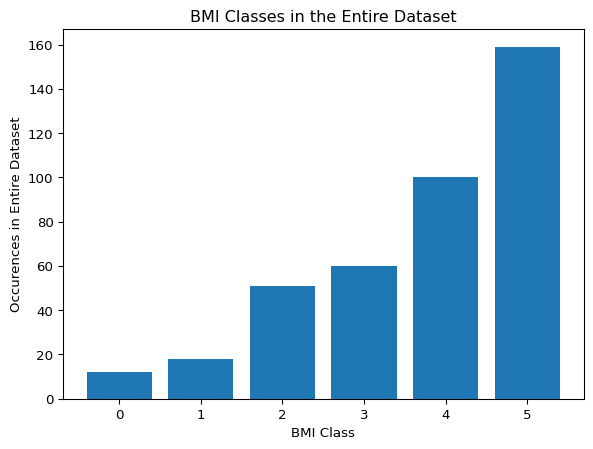

In [3]:
```{python}
# Class imbalance, more obesity.
unique_values, counts = np.unique(y, return_counts=True)
plt.bar(unique_values, counts)
plt.title("BMI Classes in the Entire Dataset")
plt.xlabel("BMI Class")
plt.ylabel("Occurences in Entire Dataset")
plt.show()
```


The labels are all discrete and sequential, consisting of whole numbers
between 0 and 5, further enforcing my intuition for using a classifier
approach. A “0” in my case represents someone with an **exeptionally
low** BMI, whereas a “5” depicts an **exceptionally high** BMI. Based on
the distribution of the data, there appears to be a huge class
imbalance, heavily favoring the amount of **exceptionally high**
instances in the dataset; this was something I needed to keep in mind
when building the classifiers for this dataset.

C:\Users\dwh71\AppData\Local\Temp\ipykernel_17876\1253239144.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


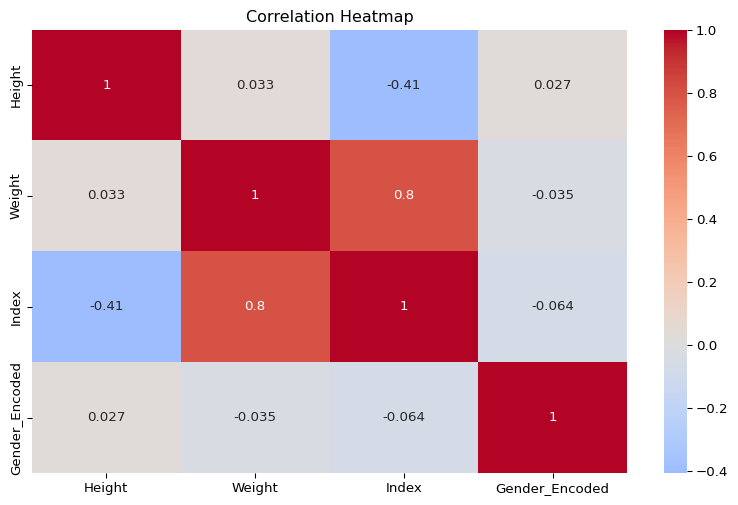

In [4]:
```{python}
correlation_matrix = data.corr()

# Display a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()
```


The correlation matrix depicts the correlation between features (height,
weight, gender, BMI) in the dataset. It uses the pearson’s correlation
coefficient to compute this: $$
 r =
  \frac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{
        \sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
$$

Based on the features presented, most are not correlated strongly, but
there is a glaring strong correlation between weight and BMI.

## Building the Decision Tree Model

In order to start the model building process, I decided to tune the
hyperparamters first by running a `GridSearch`

In [5]:
```{python}
param_grid = {
    'max_depth': [i for i in range(2, 10)],
    'min_samples_leaf': [2 ** i for i in range(0, 4)],
    'criterion': ["entropy", "gini"]
}

dt = DecisionTreeClassifier(random_state=42)

grid_search_dt = GridSearchCV(dt, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_
print("Best Hyperparameters:", best_params_dt)
print("Best Score:", grid_search_dt.best_score_)
```


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2}
Best Score: 0.815625

I recognized that `max_depth` was an important hyperparameter for the
DecisionTree (DT), as the depth of the tree heavily influences
overfitting, but other hyperparameters are important as well, such as:

-   `min_samples_leaf`: the minimum amount of samples needed in a leaf
    node of the DT. For example, when min_samples_leaf is set to 10,
    that means a node won’t split if it has fewer than 10 samples. When
    this number is higher, the model can create a more generalized tree,
    although, when the number is smaller, it’ll create more specific
    splits, resulting in a more complex tree (more potential for
    overfitting).

-   `criterion`: this hyperparameter chooses whether to use entropy or
    Gini index as a way to calculate dissimilarity in a node. I found
    that in most cases, entropy outpreformed the Gini index. $$
    Entropy(C) = -\sum_{c=1}^Cp(c)\log(p(c))
    $$

$$
Gini(C) = 1 - \sum_{c=1}^Cp(c)^2
$$

Now that I’ve determined the necessary hyperparameters for this
classifier, I initialize the `GridSearchCV` object to analyze every
combination of the above hyperparameters. Within its search, it goes
through an important cross-validation step (cv) that splits the training
data into multiple folds and iterates through each fold for each
hyperparameter combination.

There were a few options I could’ve chose from for the cv parameter in
`GridSearchCV`, but in order to account for class imbalance like I
stated earlier, I decided to go with a `StratifiedKFold`
cross-validator. StratifiedKFold accounts for class label imbalance by
keeping an equal precentage of classes for training and testing
represented in the dataset. Below is a picture representing this:

<img style="display: block;
    margin-left: auto;
    margin-right: auto;"
    height="300" width="300" src="https://amueller.github.io/aml/_images/stratified_cv.png"></img>

In [6]:
```{python}
dt = DecisionTreeClassifier(max_depth=best_params_dt["max_depth"], min_samples_leaf=best_params_dt["min_samples_leaf"], criterion=best_params_dt["criterion"])
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
```


I then created a `DecisionTreeClassifier` with the ‘best’ tuned
hyperparameters from the above grid search and populated the `y_pred`
array with the predictions from the test dataset. After that, I plotted
the tree out using Sklearn’s plot_tree method.

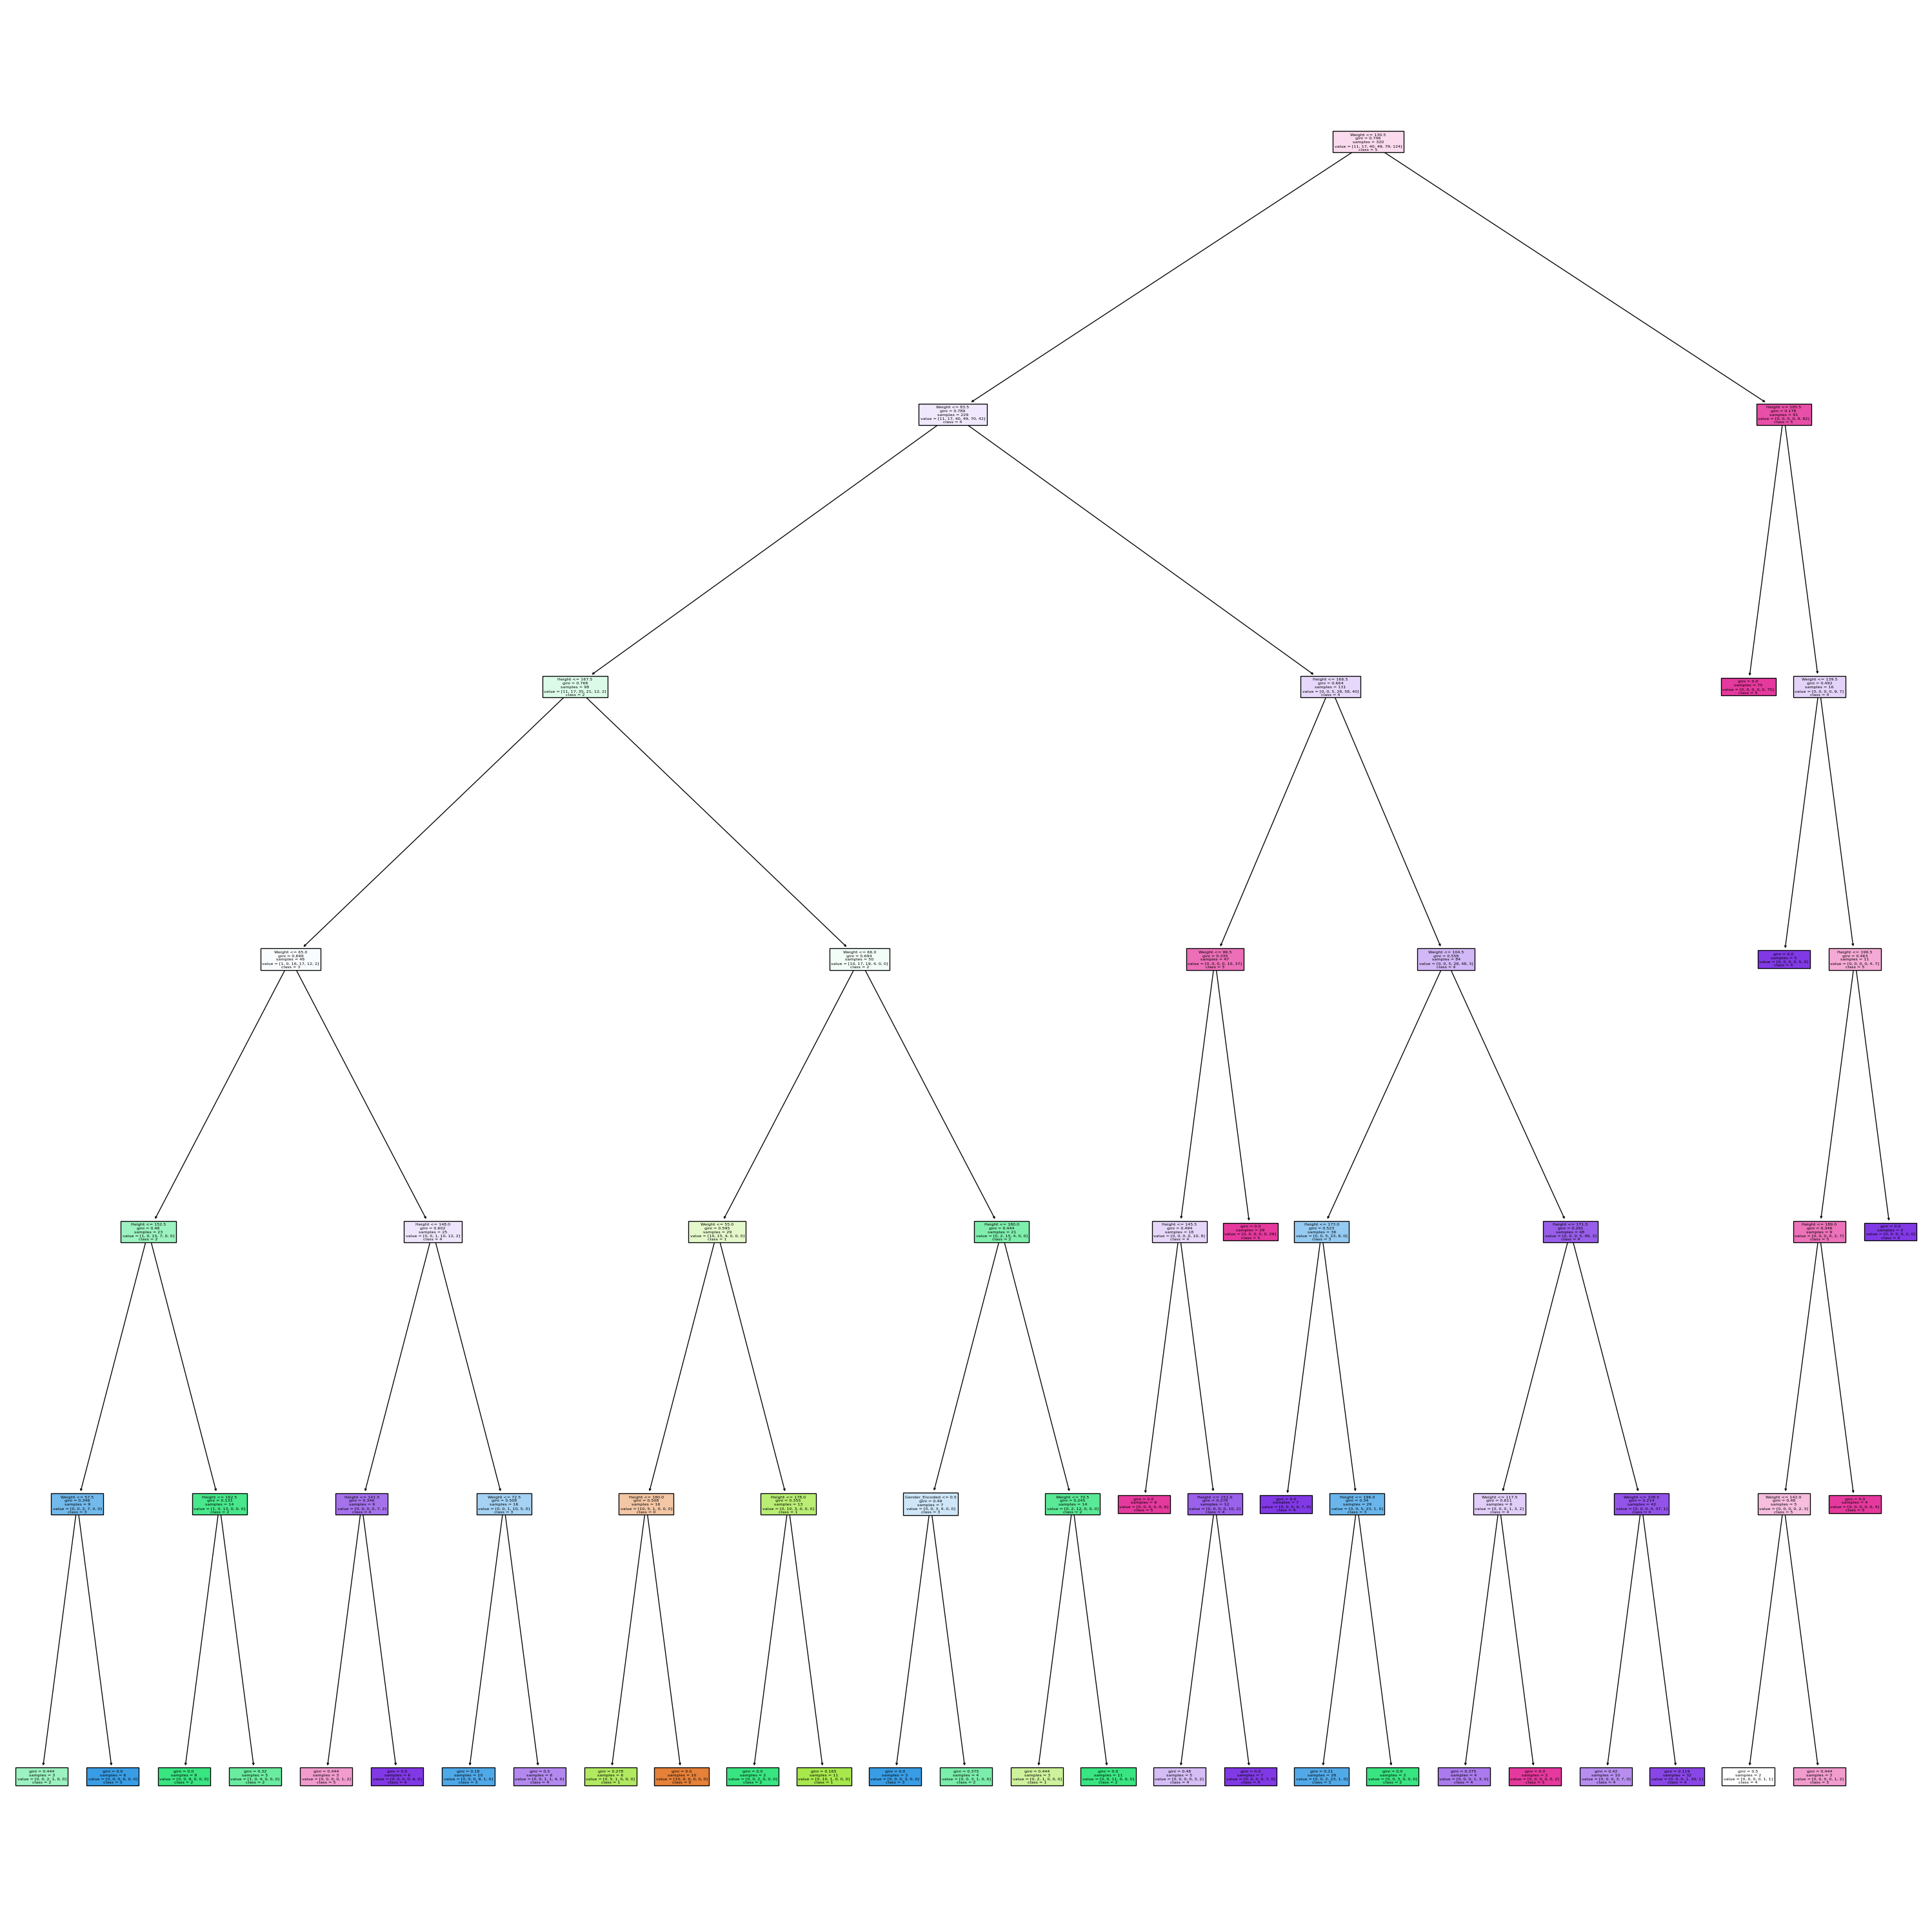

In [7]:
```{python}
plt.figure(figsize=(40, 40))
plot_tree(dt, feature_names=X_train.columns.tolist(), class_names=['0', '1', '2','3','4','5'], filled=True)
plt.show()
```


After plotting the tree, I created a confusion matrix, showing where my
predictions fell. Currently, the model sits around 75-86% accurate due
to the above hyperparameter values and the randomly generated tree with
those hyperparameter values. Not bad for a small dataset with class
imbalance.

Text(0.5, 1.0, 'Model Predictions With 77.50% Accuracy')

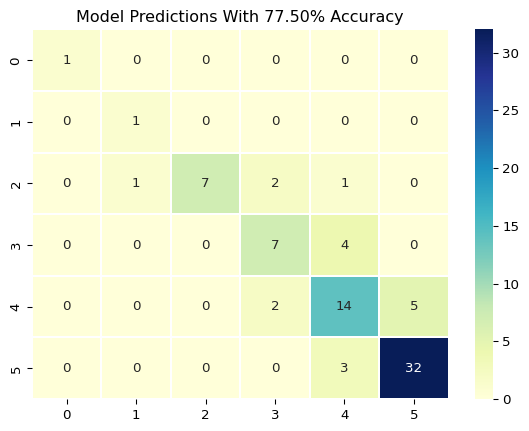

In [8]:
```{python}
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(confusion_matrix, index=[f"{i}" for i in range(6)], columns=[f"{i}" for i in range(6)])
heatmap = sns.heatmap(conf_df, annot=True, fmt="d", linewidths=0.35, cmap="YlGnBu")
plt.title(f"Model Predictions With {(np.sum(confusion_matrix.diagonal()) / y_test.shape[0]) * 100:.2f}% Accuracy")
```


## RandomForestClassifer (Ensemble approach)

As above with the `DecisionTreeClassifer`, I first started to implement
the `RandomForestClassifier` by tuning the hyperparameter values. Since
a RandomForest is just a collection of DecisionTrees,
RandomForestClassifiers, like a `DecisionTreeClassifier`, have mostly
the same hyperparameters, but the `RandomForestClassifier` has an extra
one for the amount of DecisionTrees that should be included in the
forest (`n_estimators`).

Though this step wasn’t as necessary, since I already did the
hyperparameter tuning part for the DecisionTree, but I decided to
include it again for the RandomForest with the number of estimators.

It is important to note that the `n_estimators` hyperparameter won’t
cause the model to overfit. In fact, it actually does better at
generalization when increasing the number of estimators due to the
diversity of opinions the model presents for each unique DecisionTree.
The only way overfitting can happen in a RandomForest depends on how the
underlying DecisionTrees are set up, not the quantity of them.

In [9]:
```{python}
param_grid = {
    'max_depth': [i for i in range(2, 10)],
    'min_samples_leaf': [2 ** i for i in range(0, 4)],
    'criterion': ["entropy", "gini"]
}

rf = RandomForestClassifier(random_state=42)

print(y_train.shape)
grid_search_rf = GridSearchCV(rf, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search_rf.fit(X_train, y_train.values.ravel())
best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters:", best_params_rf)
print("Best Score:", grid_search_rf.best_score_)
```


(320, 1)
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1}
Best Score: 0.828125

In [10]:
```{python}
rf = RandomForestClassifier(n_estimators=300, 
                            max_depth=best_params_rf["max_depth"], 
                            min_samples_leaf=best_params_rf["min_samples_leaf"],
                            criterion=best_params_rf["criterion"])
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_test)
```


The above code snippet creates the `RandomForestClassifier` with the
same hyperparameters as the DecisionTree, in addition to the number of
estimators (number of decision trees in the forest), trains the
classifier, then stores a prediction array.

Here is a visualizaiton of a subset of DecisionTrees in this
RandomForest:

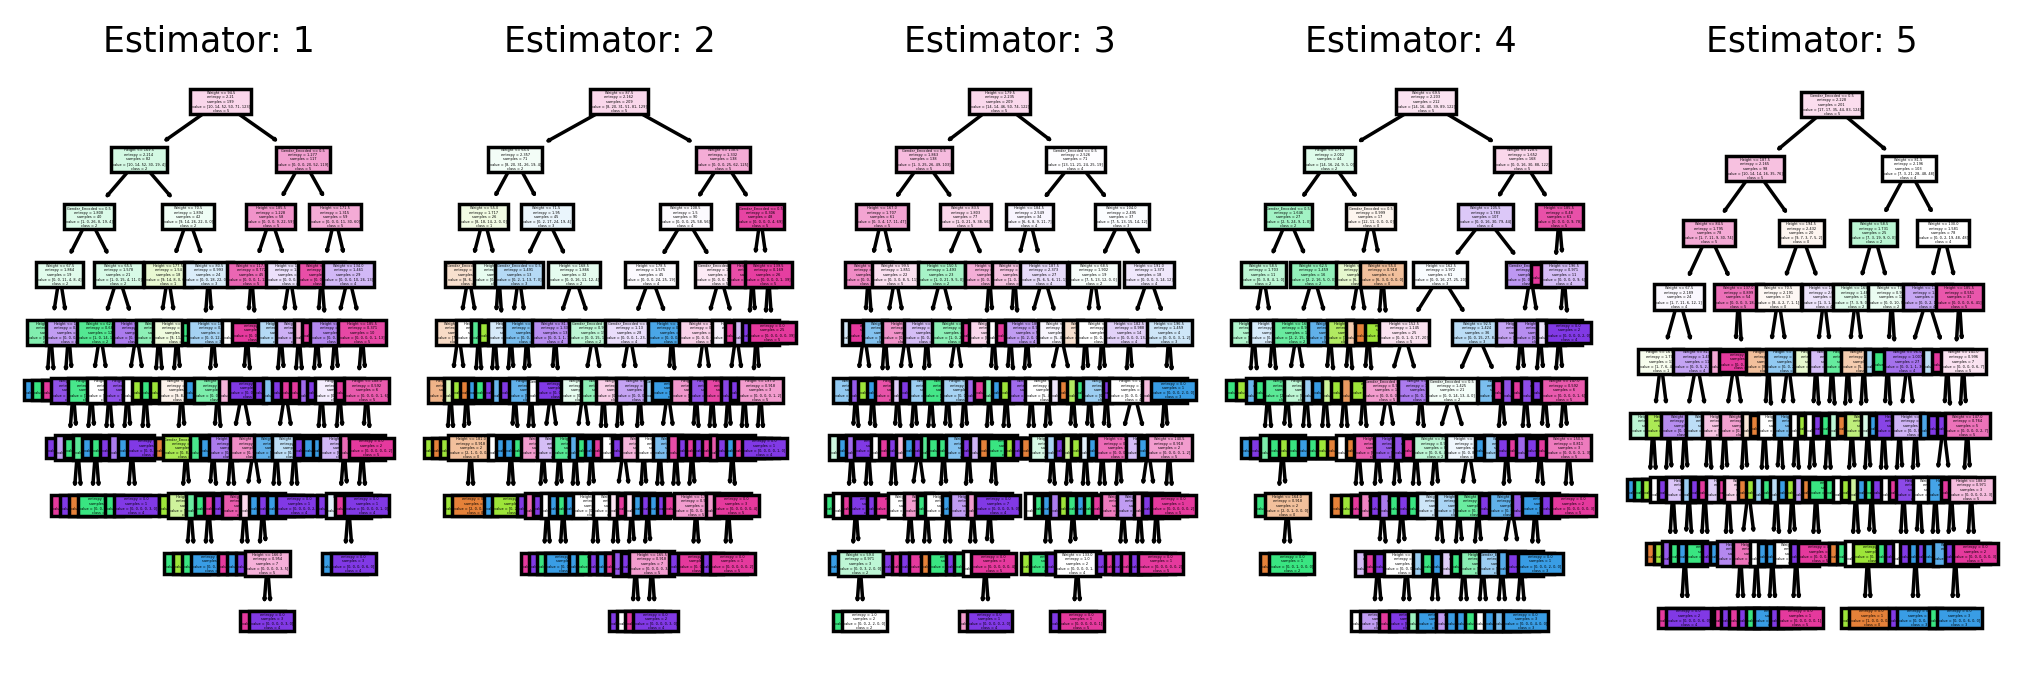

In [11]:
```{python}
    fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,3), dpi=250)
    for index in range(5):
        tree.plot_tree(rf.estimators_[index],
                    feature_names = X_train.columns.tolist(), 
                    class_names= [f"{i}" for i in range(6)],
                    filled = True,
                    ax = axes[index])

        axes[index].set_title('Estimator: ' + str(index + 1), fontsize = 10)
    plt.show()
```


After running the model, I checked the accuracy output of the prediction
array and found that the RandomForestClassifier was able to increase the
accuracy of the predictions by a considerable amount on average.

Text(0.5, 1.0, 'Model Predictions With 81.25% Accuracy')

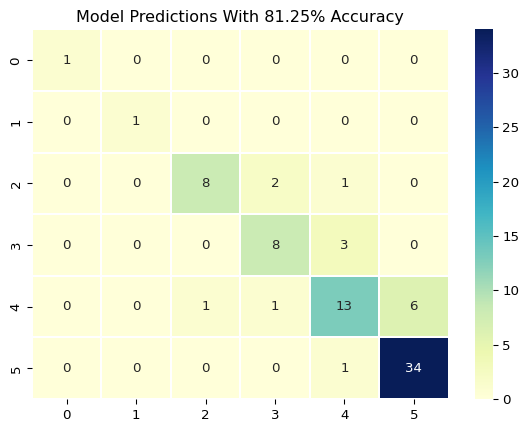

In [12]:
```{python}
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(confusion_matrix, index=[f"{i}" for i in range(6)], columns=[f"{i}" for i in range(6)])
heatmap = sns.heatmap(conf_df, annot=True, fmt="d", linewidths=0.35, cmap="YlGnBu")
plt.title(f"Model Predictions With {(np.sum(confusion_matrix.diagonal()) / y_test.shape[0]) * 100:.2f}% Accuracy")
```


Finally, I decided to calculate the accuracy preformance on multiple
samples of RandomForestClassifiers and DecisionTrees at the same time
and plot them out in a line chart.

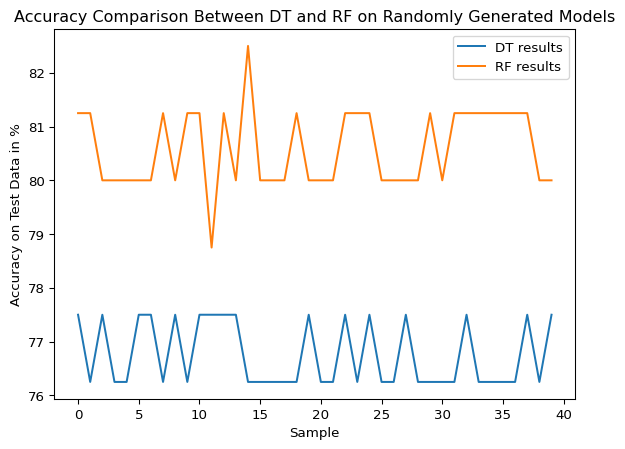

In [13]:
```{python}
'''
Plot a graph that compares the two models, randomly generated with tuned hyperparameter models
'''
dt_results = []
rf_results = []
n_samples = 40
indexes = [i for i in range(n_samples)]
for i in indexes:
    dt = DecisionTreeClassifier(max_depth=best_params_dt["max_depth"], 
                   min_samples_leaf=best_params_dt["min_samples_leaf"], criterion=best_params_dt["criterion"])
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    
    rf = RandomForestClassifier(n_estimators=300, 
                            max_depth=best_params_rf["max_depth"], 
                            min_samples_leaf=best_params_rf["min_samples_leaf"],
                            criterion=best_params_rf["criterion"])
    rf.fit(X_train, y_train.values.ravel())
    y_pred_rf = rf.predict(X_test)
    
    confusion_matrix_dt = sklearn.metrics.confusion_matrix(y_test, y_pred_dt)
    confusion_matrix_rf = sklearn.metrics.confusion_matrix(y_test, y_pred_rf)
    
    dt_results.append((np.sum(confusion_matrix_dt.diagonal()) / y_test.shape[0]) * 100)
    rf_results.append((np.sum(confusion_matrix_rf.diagonal()) / y_test.shape[0]) * 100)

plt.plot(indexes, dt_results, label="DT results")
plt.plot(indexes, rf_results, label="RF results")
plt.xlabel("Sample")
plt.ylabel("Accuracy on Test Data in %")
plt.title("Accuracy Comparison Between DT and RF on Randomly Generated Models")
plt.legend()
plt.show()
```


## Results and Conclusions

After doing simple experimentation with these models, I have found that,
on average, the RandomForestClassifier outpreforms just a singular
DecisionTreeClassifier. There are several advantages to having a forest
of DecisionTrees rather than a singular tree:

-   More generalizability due to the ensemble approach to this problem

-   Limits overfitting compared to a DT

-   DT has high variance and instability, so having a forest of them
    results in a more collective approach.

Though there is more resource complexity with a forest, the benefits of
using that over a DT is worth the tradeoff.